# Предсказание оттока клиентов оператора связи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

__Описание услуг__

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

__Описание данных__

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### План работы

__Подготовить данные для анализа__

    - проверить наличие неявных пропусков,
    - выявить явные и неявные дубликаты,
    - проверить верный формат ввода данных, привести их к соответствующему типу,
    - привести все к единообразному виду, собрав в единую таблицу,
    - провести анализ полученных объединенных данных,
    - выделить целевой признак, отражающий факт ухода клиента или продолжения взаимодействия с компанией.

__Провести анализ__

    - посмотреть на распределение целевого признака,
    - посмотреть на колличественные признаки,
    - посмотреть на распределение типов услуг между теми, кто ушел, и теми, кто продолжает получать услуги компании,
    - посмотреть на распределение типа оплаты услуг между теми, кто ушел, и теми, кто продолжает получать услуги компании.
    
__Обучить и протестировать модель__

    - подготовить данные к обучению модели с помощью кодирования и разбивки на обучающую и тестовую выборку
    - выбрать модели для обучения
    - посмотреть на качество моделей по скорости обучения модели и качеству на основе выбранных метрик (ROC AUC),
    - выбрать лучшую модель и посмотреть на финальную оценку по выбранным метрикам.
    
__Подготовить отчет__

    - подготовить отчет по результатом работы с подведением выводов и рекомендациями в соответствии с полученными данным по результатам работы модели.

### Цель проекта

На основе полученных данных построить модель, которая сможет с достаточной достоверностью прогнозировать отток клиентов компании, что позволит компании заранее выделять группы клиентов, которые требуют дополнительного внимания и мер по их удержанию.

In [1]:
import sys
!{sys.executable} -m pip install phik
!{sys.executable} -m pip install scikit-learn==1.1.3

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder


import phik

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 190623

In [2]:
# Функция обзора данных датафрейма

def df_review(df):
    display(df.head(10))
    display(df.info())
    
# Функция вывода графиков по признакам датафрейма    
def plot(df, col_type):
    if (col_type == 'num'):
        cols = 3
        rows = 2
        plt.figure(figsize=(15, 10))
        i = 0
        for column in col_numeric:
            i += 1 
            plt.subplot(rows, cols, i)
            plt.hist(df[column])
            plt.title(column)
        for column in col_numeric:
            i += 1 
            plt.subplot(rows, cols, i)
            plt.boxplot(df[column])
            plt.title(column)

        plt.show()
        display(df[col_numeric].describe())
        
    elif (col_type == 'cat'):
        cols = 3
        rows = int(np.ceil(len(col_categorial) / cols))
        plt.figure(figsize=(20, 35))
        for i, column in enumerate(col_categorial):
            ax = plt.subplot(rows, cols, i+1)
            df[column].value_counts().plot(
                kind='bar', 
                title=column, 
                ax=ax,
                rot=0,
            )
        plt.show()

## Знакомство с данными

### Обзор данных

Для знакомства с данными откроем файлы и выведем:
    
1. Первые 10 строк таблицы

2. Общую информацию по таблице

In [3]:
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')   
    df_phone = pd.read_csv('/datasets/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

__df_contract__

In [4]:
df_review(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

В таблице с контрактами представлено восемь столбцов и 7043 строки. Пропусков данных нет, но необходимо проверить, что внесено в колонки с данными типа object. Особого внимания тебуют столбцы BeginDate, EndDate, TotalCharges, которые представлены не в ожидаемом типе.

In [5]:
df_contract['BeginDate'].sort_values().unique()

array(['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
       '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
       '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
       '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
       '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
       '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-

In [6]:
df_contract['EndDate'].sort_values().unique()

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

In [7]:
df_contract['Type'].sort_values().unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [8]:
df_contract['PaymentMethod'].sort_values().unique()

array(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'], dtype=object)

In [9]:
df_contract['MonthlyCharges'].sort_values().unique()

array([ 18.25,  18.4 ,  18.55, ..., 118.6 , 118.65, 118.75])

In [10]:
df_contract['TotalCharges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

In [11]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


У нас есть 11 записей в таблице контрактов, где отсутствуют данные в столбце TotalCharges. Это контракты, заключенные 1 февраля, по которым еще не осуществлялась оплата. По сути, эти данные не помогут машинному обучению и могут быть удалены из датасета.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

__df_personal__

In [12]:
df_review(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

In [13]:
df_personal['gender'].sort_values().unique()

array(['Female', 'Male'], dtype=object)

In [14]:
df_personal['SeniorCitizen'].sort_values().unique()

array([0, 1])

In [15]:
df_personal['Partner'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

In [16]:
df_personal['Dependents'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

В данной таблице также представлено 7043 записи, данные в колонке SeniorCitizen представлены в другом формате, относительно остальных колонок, однако также корректно.

__df_internet__

In [17]:
df_review(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [18]:
df_internet['InternetService'].sort_values().unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [19]:
df_internet['OnlineSecurity'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

In [20]:
df_internet['OnlineBackup'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

In [21]:
df_internet['DeviceProtection'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

In [22]:
df_internet['TechSupport'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

In [23]:
df_internet['StreamingTV'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

In [24]:
df_internet['StreamingMovies'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

В данной таблице представлено меньше записей - 5517. Можно предположить, что представлены только данные клиентов, пользующихся услугами интернет-подключения. Все данные представлены корректно.

__df_phone__

In [25]:
df_review(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [26]:
df_phone['MultipleLines'].sort_values().unique()

array(['No', 'Yes'], dtype=object)

В последней таблице также представлено меньше записей - 6361. Присутствует колонка только с одним признаком - наличие подключенной услуги мультиканальной линии. Можно предположить, что у остальных клиентов в данном списке в наличии подключенная услуга одноканальной телефонии.

__Вывод:__ 

Для исследования предоставлены данные о клиентах компании в четырех таблицах, которые связаны друг с другом по колонке __customerID__.

Таблица __df_contract__ - информация о договоре:

    customerID - уникальный ID клиента;
    BeginDate - дата заключения договора;
    EndDate - дата расторжения договора;
    Type - тип оплаты (ежемесячный платёж, договор на один или два года);
    PaperlessBilling - расчет по электронному чеку;
    PaymentMethod - способы оплаты;
    MonthlyCharges - ежемесячный платеж;
    TotalCharges - общая сумма платежей на 20.01.2020.

Таблица __df_personal__ - информация о клиентах:

    customerID - уникальный ID клиента;
    gender - пол;
    SeniorSitizen - достижения пенсионного возраста;
    Partner - наличие супруга(и);
    Dependents - наличие иждевенцев.

Таблица __df_internet__ - информация об интернет-услугах:

    customerID - уникальный ID клиента;
    InternetService - тип интернет-соединения;
    OnlineSecurity - услуга блокировки небезопасных сайтов;
    OnlineBackup - услуга облачного хранилища файлов;
    DeviceProtection - услуга антивируса;
    TechSupport - услуга выделенной линии технической поддержки
    StreamingTV - услуга стримингового телевидения;
    StreamingMovies - услуга онлайн-кинотеатра.

Таблица __df_phone__ - информация об услугах телефонии:

    customerID - уникальный ID клиента;
    MultipleLines - наличие мультиканальной линии.

В таблицах с контрактами и персональными данными представлено 7043 записи, в таблицах с данными по интернет-услугам и услугах телефонии записей меньше (5517 и 6361 соответственно). Логично предположить, что у части клиентов подключены только интернет-услуги, у части - только услуги телефонии, а у части - и те и те.

## Предобработка данных

### Объединение в единую таблицу

Для начала дополним таблицы internet и  phone дополнительными одноименными признаками, отражающими то, что данные пользователи подключены к услугам интернета или телефона вообще. После объединим таблицы в одну.

In [27]:
df_internet['internet'] = 1
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
 8   internet          5517 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 388.0+ KB


In [28]:
df_phone['phone'] = 1
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
 2   phone          6361 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 149.2+ KB


In [29]:
df =  df_contract \
    .merge(df_personal, how='left', on='customerID') \
    .merge(df_internet, how='left', on='customerID') \
    .merge(df_phone, how='left', on='customerID')

df_review(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,1.0,No,1.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,1.0,NaN,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,Fiber optic,No,No,No,No,No,No,1.0,No,1.0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,Fiber optic,No,No,Yes,No,Yes,Yes,1.0,Yes,1.0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Fiber optic,No,Yes,No,No,Yes,No,1.0,Yes,1.0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,DSL,Yes,No,No,No,No,No,1.0,NaN,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,1.0,Yes,1.0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

Переименуем названия столбцов в snake_case. 

In [30]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str.replace("_", "", 1)
df = df.rename(columns={'customeri_d': 'customer_id'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

### Добавление целевого признака

Добавим целевой признак. Т.к. наша задача работать с оттоком клиентов, назовем его __clients_left__ и выделим из столбца __end_date__. Если значение в столбце равно "No", то признак равен 0, поскольку клиент продолжает пользоваться услугами компании. Если дата ухода присутствует, то целевой признак равен 1.

In [31]:
df['clients_left'] = (df['end_date'] != 'No').astype(int)
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,internet,multiple_lines,phone,clients_left
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,Yes,No,No,No,No,1.0,NaN,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,Yes,No,Yes,No,No,No,1.0,No,1.0,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,Yes,Yes,No,No,No,No,1.0,No,1.0,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,Yes,No,Yes,Yes,No,No,1.0,NaN,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,No,No,No,No,No,1.0,No,1.0,0


### Обработка дубликатов, пропусков и приведение типов данных к соответствующему формату

Проверим данные на дубликаты.

In [32]:
df.duplicated().sum()

0

Также проверим, что значения поля custoimer_id уникальны.

In [33]:
df['customer_id'].is_unique

True

Уточним данные с пропусками в объединенной таблице.

In [34]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
internet             1526
multiple_lines        682
phone                 682
clients_left            0
dtype: int64

Пропуски в столбцах перенесенных из таблиц internet и phone говорят о том, что услуги не подключены - заполним их значением 'No', а добавочные признаки значением 0.

In [35]:
#df = df.fillna('unknown')

for column in ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines'):
    df[column] = df[column].fillna('No')
for column in ('phone', 'internet'):
    df[column] = df[column].fillna(0)
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
internet             0
multiple_lines       0
phone                0
clients_left         0
dtype: int64

Произведем необходимые преобразования типов данных.

Для этого заменим в столбце __end_date__ значение 'No' на дату представления информации, а после преобразуем два столбца __end_date__ и __begin_date__ в формат даты, а столбец __total_charges__ в числовой тип. 

In [36]:
df['end_date'] = df['end_date'].replace(['No'], ['2020-02-01'])
df.query('end_date == "No"')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,internet,multiple_lines,phone,clients_left


In [37]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')


Выделим в отдельный период признак количества дней, в течении которых клиент пользовался услугами (на 2020-02-01).

In [38]:
df['duration'] = (df['end_date'] - df['begin_date']).dt.days
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

Не забудем, что в 11 строках в столбце __total_charges__ стоит пробел, что было выявлено при первичном знакомстве с данными. Удалим эти строки, а после приведем столбец к числовому значению.

In [39]:
df = df.query("total_charges != ' '")

In [40]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors ='coerce')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

Также установим customer_id в качестве индекса в получившейся таблице

In [42]:
df = df.set_index('customer_id')

In [43]:
df_review(df)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,internet,multiple_lines,phone,clients_left,duration
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,Yes,No,No,No,No,1.0,No,0.0,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,No,Yes,No,No,No,1.0,No,1.0,0,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,Yes,No,No,No,No,1.0,No,1.0,0,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,No,Yes,Yes,No,No,1.0,No,0.0,0,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,No,No,No,No,No,1.0,No,1.0,0,153
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,...,No,Yes,No,Yes,Yes,1.0,Yes,1.0,0,337
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,...,Yes,No,No,Yes,No,1.0,Yes,1.0,0,671
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,...,No,No,No,No,No,1.0,No,0.0,0,306
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,...,No,Yes,Yes,Yes,Yes,1.0,Yes,1.0,0,945


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7032 non-null   datetime64[ns]
 1   end_date           7032 non-null   datetime64[ns]
 2   type               7032 non-null   object        
 3   paperless_billing  7032 non-null   object        
 4   payment_method     7032 non-null   object        
 5   monthly_charges    7032 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7032 non-null   object        
 8   senior_citizen     7032 non-null   int64         
 9   partner            7032 non-null   object        
 10  dependents         7032 non-null   object        
 11  internet_service   7032 non-null   object        
 12  online_security    7032 non-null   object        
 13  online_backup      7032 non-null   object        
 14

None

__Вывод:__ После предобработки все данные были собраны в одну таблицу, добавлены целевой признак и два признака, обозначающие наличие или отсутствие использования услуг интернета или телефонии воообще, а также произведена проверка на дубликаты, заполнены возникшие при преобразовании пропуски за исключением 11 строк с данными по клиентам, которые на дату представления информации только заключили договор и не играют роли для обучения модели. Индекс в полученной таблице был установлен по колонке customer_id.

## Анализ данных

Для начала посмотрим на распределение целевого признака.

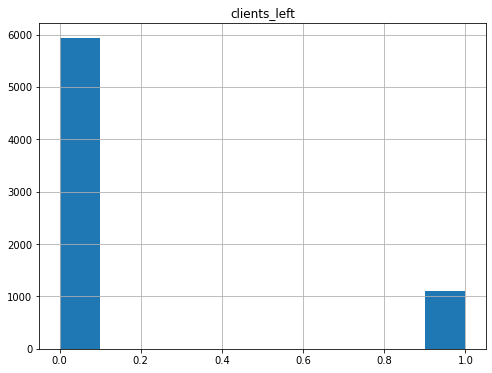

In [44]:
df['clients_left'].hist(figsize=(8,6))
plt.title('clients_left');

Можно наблюдать значительный перевес в сторону продолжающих пользоваться услугами. Классы не сбалансированы.

Выведем, как распределились значения категориальных признаков.

In [45]:
col_numeric = ['monthly_charges', 'total_charges', 'duration']
col_categorial = [
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service', 
    'online_security', 
    'online_backup', 
    'device_protection', 
    'tech_support', 
    'streaming_t_v', 
    'streaming_movies', 
    'multiple_lines',
    'phone',
    'internet'
]

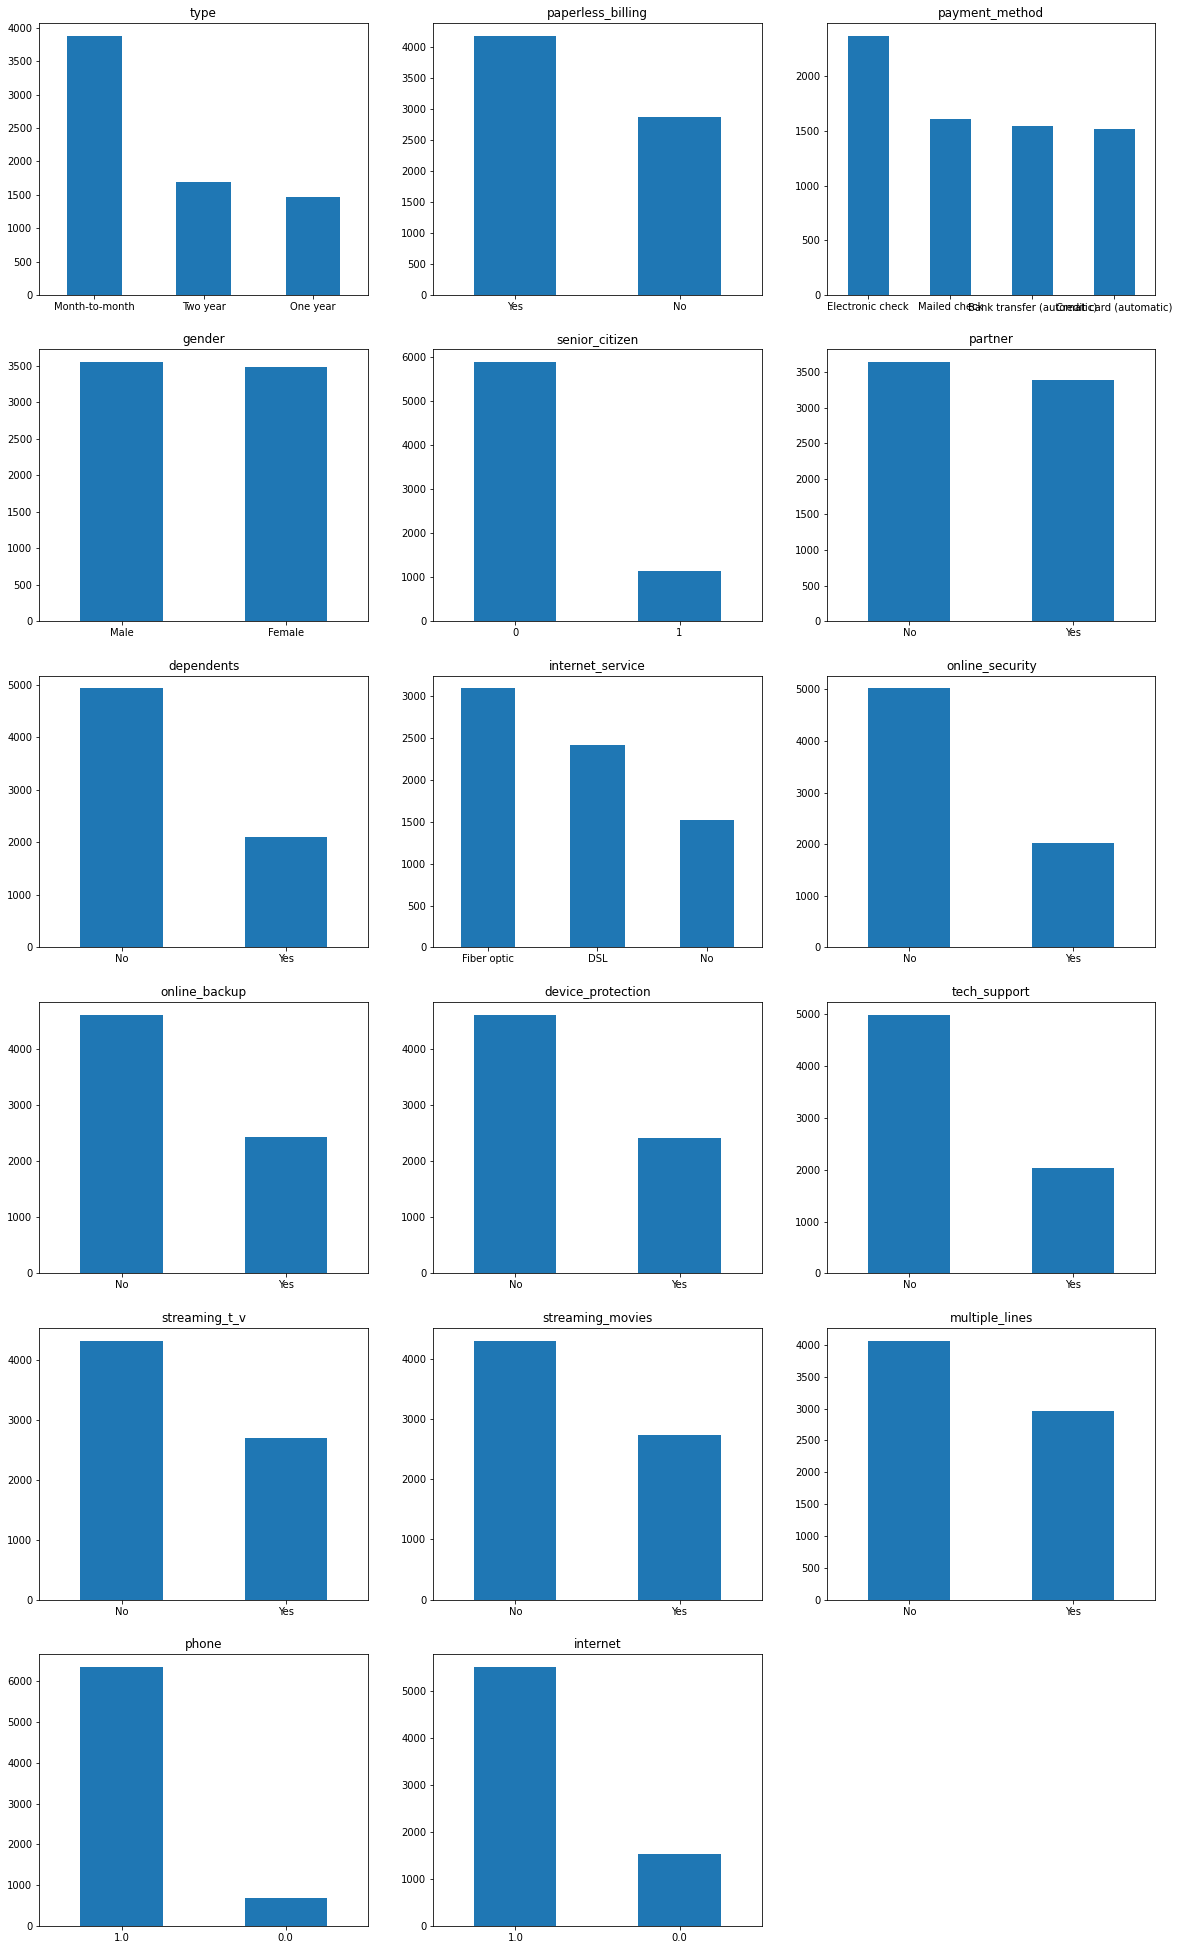

In [46]:
plot(df, 'cat')

Можно выделить несколько факторов:

- клиенты предпочитают ежемесячную оплату услуг
- электронные платежи и электронные чеки предпочитают чаще
- количество мужчин и женщин примерно одинаковое, как и количество людей с партнерами и без
- количество клиентов пенсионного возраста не велико, также большинство клиентов не обладает иждевенцами
- клиенты предпочитают подключение по оптоволокну
- дополнительные услуги не пользуются большой популярностью
- только телефонными услугами пользуется больше клиентов, чем только интернет услугами


Выведем информацию по количественным данным.

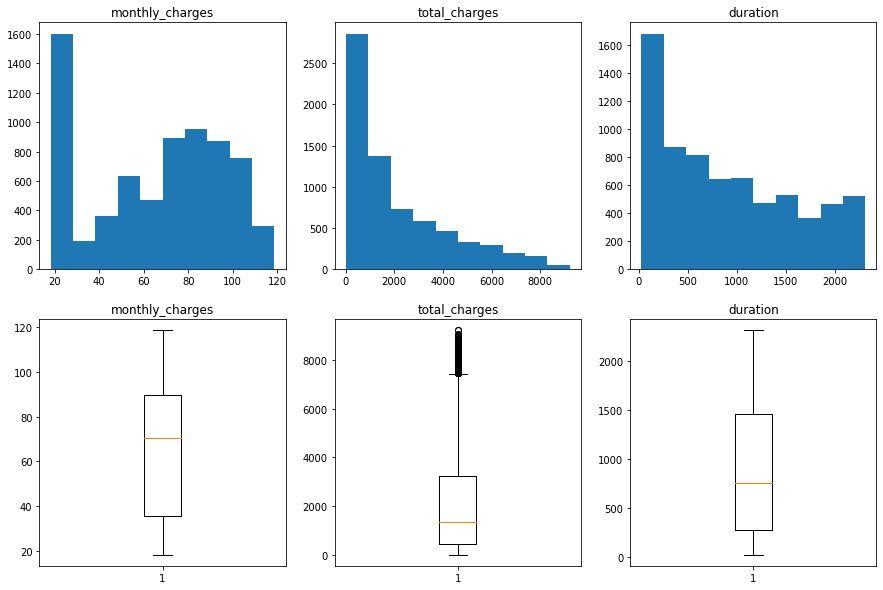

,monthly_charges,total_charges,duration
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,899.961320
std,30.085974,2112.736199,682.738777
min,18.250000,19.050000,28.000000
25%,35.587500,439.745000,276.000000
50%,70.350000,1345.275000,761.000000
75%,89.862500,3239.317500,1461.000000
max,118.750000,9221.380000,2314.000000


In [47]:
plot(df, 'num')

Видно убывание графика общих платежей, при этом график ежемесячных платежей дает два пика - самый базовый и в районе 85, что показывает, что те, кто платят большую ежемесячную плату не остаются клиентами компании продолжительное время. В столбже с общей длительностью пользолвания услугами компании виден большой пик вначале, а после - достаточно стабильное распределение с просадкой на уровне 1800 дней.


Проверим наблюдения.

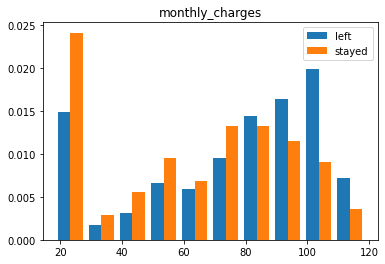

In [48]:
plt.hist([df[df.clients_left == 1].monthly_charges, df[df.clients_left == 0].monthly_charges], label=['left', 'stayed'], density=True);
plt.legend();
plt.title('monthly_charges');
plt.show();

График подтверждает, что среди ушедших клиентов больше тех, кто приобретал услуг на большую сумму.

Посмотрим как распределяются пользователи интернета и телефонии среди клиентов с наименьшей ежемесячной платой.

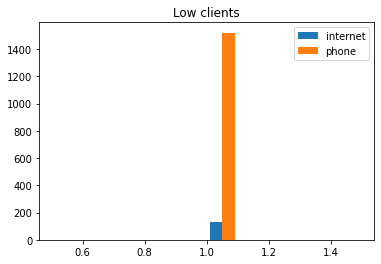

In [49]:
plt.hist([df.query('monthly_charges < 30')[df.query('monthly_charges < 30').internet == 1].internet, df.query('monthly_charges < 30')[df.query('monthly_charges < 30').phone == 1].phone], label=['internet', 'phone']);
plt.legend();
plt.title('Low clients');
plt.show();

Т.е. среди клиентов с наименьшей ежемесячной платой, которые в основном продолжают пользоваться услугами, в основном клиенты телефонии, а не интернета.

Теперь подготовим данные для обучения модели и посмотрим на мультиколлинеарность признаков.

Для начала уберем не нужные для обучения столбцы с датами (данные по количеству дней взаимодействия с клиентом останутся)

In [50]:
df = df.drop(['end_date', 'begin_date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   gender             7032 non-null   object 
 6   senior_citizen     7032 non-null   int64  
 7   partner            7032 non-null   object 
 8   dependents         7032 non-null   object 
 9   internet_service   7032 non-null   object 
 10  online_security    7032 non-null   object 
 11  online_backup      7032 non-null   object 
 12  device_protection  7032 non-null   object 
 13  tech_support       7032 non-null   object 
 14  streaming_t_v      7032 non-null   object 
 15  streaming_movies   7032 non-null   object 
 16  internet      

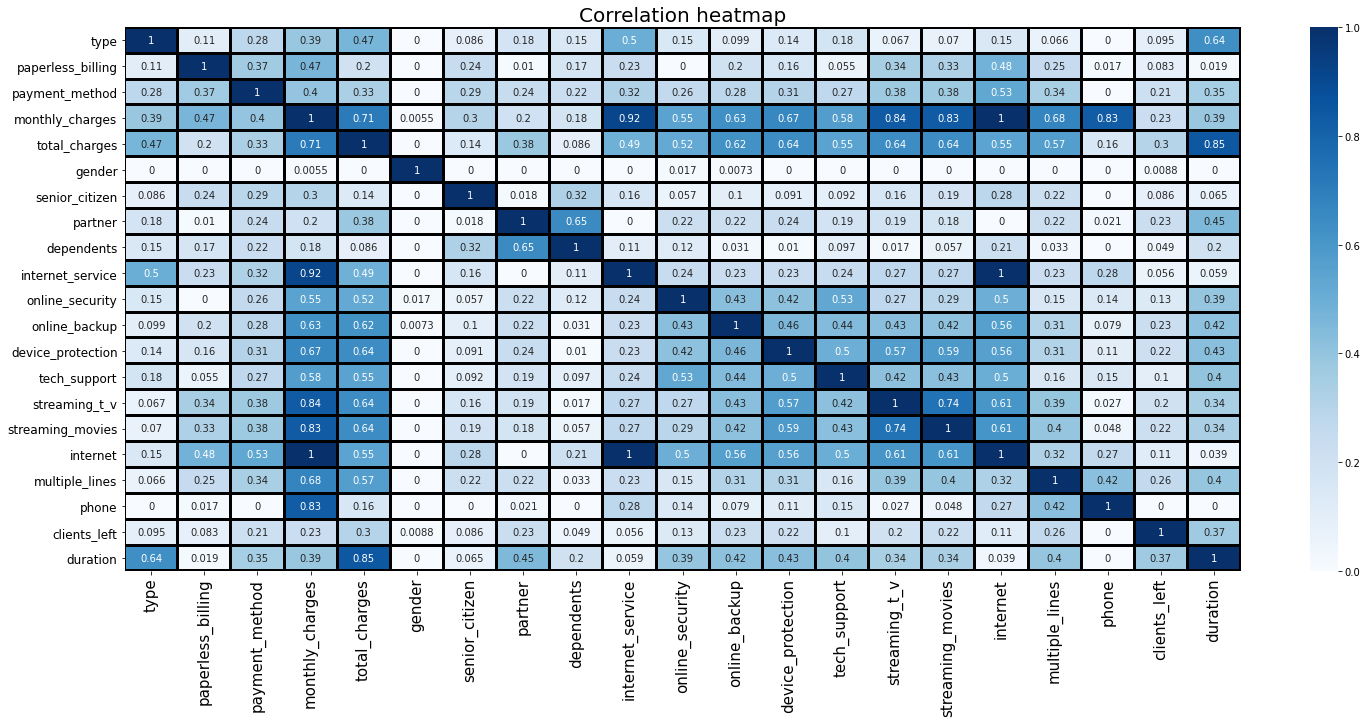

In [51]:
plt.figure(figsize=(25, 10))
sns.heatmap(
    df.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration', 'senior_citizen']),
    annot=True,
    linewidths=2,
    linecolor='black',
    cmap='Blues'
);
plt.title('Correlation heatmap', size=20)
plt.xticks(size=15)
plt.yticks(size=12)
plt.show();

bНаибольшая корреляция целевого признака возникает с признаком duration и total_charges, что может говорить о том, что уход клиента из компании связан с продолжительностью пребывания в компании и общей суммой платежей, что сочетается с предыдущим наблюдением, что среди ушелших клиентов больше тех, кто приобретал услуг на большую сумму.

Удалим неинформативные признаки: 
* gender (отсутствие взаимосвязи с какой-либо из категорий), 
* senior_sitizens (есть корреляция с оплатой услуг, что может быть причиной ненулевой корелляции с целевым признаком, но скорее всего это не говорит о том, что пожилые клиенты покидают компанию из-за фактора возраста), 
* dependents (есть корреляция с семейным положением, от чего и возникает корреляция с целевым признаком), 
* высокая мультиколлинеарность наблюдается среди признаков наличия дополнительных интернет услуг. Оставим только те, которые имеют достаточно высокую корреляцию с целевым признаком,
* уберем признаки internet  и  phone (искуственные признаки, введеные для первичного объединения таблиц и анализа). Также можно убрать признак total_charges - у него возникаетсильная корреляция с признаком duration, что объясняется просто тем, что чем больше клиент остается с компанией, тем больше растет общая сумма его платежей. При этом уже были удалены даты начала и завершения обслуживания клиента (чтобы предотвратить возможную утечку при работе моделей), а значит восстановить "жизнь клиента" будет затруднительно. При этом оставшиеся признаки duration и montly_charge в случае необюходимости позволят восстановить признак total_charge.

In [52]:

df.drop(['gender','dependents', 'senior_citizen', 'internet', 'phone', 'total_charges', 'streaming_t_v', 'tech_support', 'online_security'], axis=1, inplace=True)


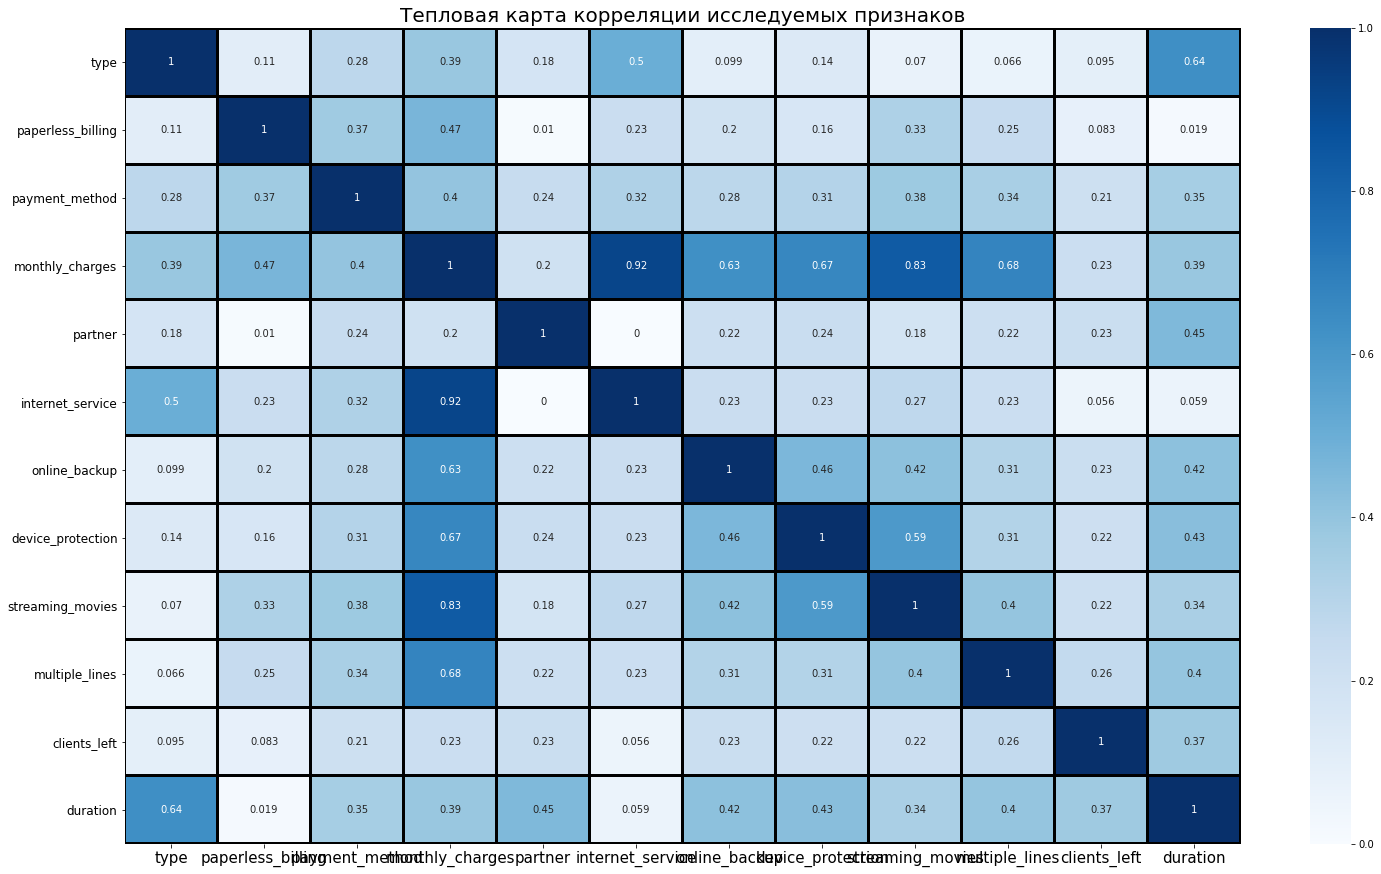

In [53]:
plt.figure(figsize=(25, 15))
sns.heatmap(
    df.phik_matrix(interval_cols=['monthly_charges', 'duration']),
    annot=True,
    linewidths=2,
    linecolor='black',
    cmap='Blues'
);
plt.title('Тепловая карта корреляции исследуемых признаков', size=20)
plt.xticks(size=15)
plt.yticks(size=12)
plt.show();

__Вывод:__ В ходе анализа данных были уточнены соотношения классов целевого признака (классы не сбалансированны). Был выведен общий портрет клиента по категориальным признакам: предпочитает ежемесячную оплату услуг, чаще предпочитает электронные платежи и электронные чеки, предпочитает подключение по оптоволокну, не сильно любит подключать дополнительные услуги, чаще пользуется только телефонными услугами нежели только интернет услугами. При этом среди ушедших клиентов больше тех, кто приобретал услуг на большую сумму. 

## Обучение моделей

В качестве моделей выберем следующие:
* Модель логистической регрессии
* Модель дерева решений
* Модель случайного леса
* Модель CatBoostClassifier

### Подготовка данных для моделей

Разделим данные на выборки.

In [54]:
target = df['clients_left']
features = df.drop('clients_left', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE,
                                                                            stratify = target
)

display(features_train.shape, features_test.shape)

(5274, 11)

(1758, 11)

Проверим распределение ключевого признака по выборкам

In [55]:
display(target_train.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
display(target_test.value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

0    84.3%
1    15.7%
Name: clients_left, dtype: object

0    84.4%
1    15.6%
Name: clients_left, dtype: object

Проведем масштабирование количественных признаков.

Закодируем признаки. Применим кодировку OHE.

In [56]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
display(ohe_features)
col_numeric = ['monthly_charges', 'duration']

['type',
 'paperless_billing',
 'payment_method',
 'partner',
 'internet_service',
 'online_backup',
 'device_protection',
 'streaming_movies',
 'multiple_lines']

In [57]:
features_train_ohe = features_train.copy()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_ohe[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

features_train_scaler = features_train_ohe.copy()

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train_scaler[col_numeric] = scaler.fit_transform(features_train_scaler[col_numeric])

# смотрим на результат
features_train_scaler.head()

,monthly_charges,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,internet_service_Fiber optic,internet_service_No,online_backup_Yes,device_protection_Yes,streaming_movies_Yes,multiple_lines_Yes
customer_id,,,,,,,,,,,,,,,
8191-XWSZG,-1.479147,1.022683,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7055-VKGDA,1.349624,1.247661,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5543-QDCRY,-0.285890,-1.125637,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2927-QRRQV,0.990812,0.753592,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
6502-MJQAE,0.154698,-1.171220,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Подбор лучших гиперпараметров

#### Модель логистической регрессии

In [58]:
%%time

model = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)

param_grid ={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C':[0.001, 0.01, 0.1, 1, 10, 100]}

tuning_model_lr = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=3, n_jobs=-1)
tuning_model_lr.fit(features_train_scaler, target_train)

display(tuning_model_lr.best_params_)
display(tuning_model_lr.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .........C=0.001, solver=newton-cg;, score=0.629 total time=   0.1s
[CV 2/5] END .........C=0.001, solver=newton-cg;, score=0.721 total time=   0.4s
[CV 3/5] END .........C=0.001, solver=newton-cg;, score=0.731 total time=   0.3s
[CV 4/5] END .........C=0.001, solver=newton-cg;, score=0.712 total time=   0.2s
[CV 5/5] END .........C=0.001, solver=newton-cg;, score=0.686 total time=   0.4s
[CV 1/5] END .............C=0.001, solver=lbfgs;, score=0.629 total time=   0.1s
[CV 2/5] END .............C=0.001, solver=lbfgs;, score=0.721 total time=   0.1s
[CV 3/5] END .............C=0.001, solver=lbfgs;, score=0.731 total time=   0.1s
[CV 4/5] END .............C=0.001, solver=lbfgs;, score=0.712 total time=   0.1s
[CV 5/5] END .............C=0.001, solver=lbfgs;, score=0.686 total time=   0.1s
[CV 1/5] END .........C=0.001, solver=liblinear;, score=0.490 total time=   0.1s
[CV 2/5] END .........C=0.001, solver=liblinear

{'C': 1, 'solver': 'sag'}

0.7578781132981585

CPU times: user 12.7 s, sys: 24.5 s, total: 37.2 s
Wall time: 37.5 s


#### Модель решающего дерева

In [59]:
%%time
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
    
param_grid = {'max_depth': range(1, 8),
              'min_samples_leaf' : range (1,6),
              'max_features' : range(1,7)}

tuning_model_dt = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=3, n_jobs=-1)
tuning_model_dt.fit(features_train_ohe, target_train)
display(tuning_model_dt.best_params_)
display(tuning_model_dt.best_score_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV 1/5] END max_depth=1, max_features=1, min_samples_leaf=1;, score=0.527 total time=   0.0s
[CV 2/5] END max_depth=1, max_features=1, min_samples_leaf=1;, score=0.541 total time=   0.0s
[CV 3/5] END max_depth=1, max_features=1, min_samples_leaf=1;, score=0.545 total time=   0.0s
[CV 4/5] END max_depth=1, max_features=1, min_samples_leaf=1;, score=0.531 total time=   0.0s
[CV 5/5] END max_depth=1, max_features=1, min_samples_leaf=1;, score=0.528 total time=   0.0s
[CV 1/5] END max_depth=1, max_features=1, min_samples_leaf=2;, score=0.527 total time=   0.0s
[CV 2/5] END max_depth=1, max_features=1, min_samples_leaf=2;, score=0.541 total time=   0.0s
[CV 3/5] END max_depth=1, max_features=1, min_samples_leaf=2;, score=0.545 total time=   0.0s
[CV 4/5] END max_depth=1, max_features=1, min_samples_leaf=2;, score=0.531 total time=   0.0s
[CV 5/5] END max_depth=1, max_features=1, min_samples_leaf=2;, score=0.528 total time=   0

{'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 2}

0.7869131531036068

CPU times: user 10.2 s, sys: 357 ms, total: 10.6 s
Wall time: 10.8 s


#### Модель случайного леса

In [60]:
%%time
model = RandomForestClassifier(random_state=RANDOM_STATE)
    
param_grid = {'max_depth': range(1, 8),
             'n_estimators' : [5, 10, 20, 50],
              'min_samples_leaf' : range (1,6),
              'max_features' : range(1,7)}

tuning_model_rf = GridSearchCV(model, param_grid, cv = 5, scoring='roc_auc', n_jobs = -1, verbose=3)

tuning_model_rf.fit(features_train_ohe, target_train)
display(tuning_model_rf.best_params_)
display(tuning_model_rf.best_score_)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
[CV 1/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=5;, score=0.606 total time=   0.0s
[CV 2/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=5;, score=0.689 total time=   0.0s
[CV 3/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=5;, score=0.722 total time=   0.0s
[CV 4/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=5;, score=0.692 total time=   0.0s
[CV 5/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=5;, score=0.700 total time=   0.0s
[CV 1/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=10;, score=0.630 total time=   0.0s
[CV 2/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=10;, score=0.719 total time=   0.0s
[CV 3/5] END max_depth=1, max_features=1, min_samples_leaf=1, n_estimators=10;, score=0.726 total time=   0.0s
[CV 4/5] END max_depth=1, max_features=1, min_samples

{'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 50}

0.835892036874915

CPU times: user 4min 41s, sys: 3.7 s, total: 4min 45s
Wall time: 4min 49s


#### Модель CatboostClassifier

In [61]:
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
    

param_grid ={'max_depth': [3,4,5],
              'n_estimators':[100, 200, 300],
              'learning_rate': [0.01,0.05,0.1],
              'border_count': [128]}

tuning_model_cb = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
tuning_model_cb.fit(features_train_scaler, target_train)

display(tuning_model_cb.best_params_)
display(tuning_model_cb.best_score_)

{'border_count': 128,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300}

0.9050604480770434

Лучший результат демонстритурет модель CatBoostClassifier - 0.90, ее и будем использовать на тестовой выборке.

### Тестирование лучшей модели

Проведем тестирование лучшей модели.

In [62]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test[col_numeric] = scaler.transform(
    features_test[col_numeric]
)

# смотрим на результат
features_test.head()

,monthly_charges,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,internet_service_Fiber optic,internet_service_No,online_backup_Yes,device_protection_Yes,streaming_movies_Yes,multiple_lines_Yes
customer_id,,,,,,,,,,,,,,,
1335-MXCSE,-0.324274,1.066797,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5597-GLBUC,0.683736,-1.125637,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8313-KTIHG,-0.122338,-1.125637,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4455-BFSPD,1.207768,1.424115,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
4501-EQDRN,0.158036,-1.215334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [63]:
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, 
                           border_count=128, learning_rate=0.1, max_depth=5, n_estimators=300)

model.fit(features_train_scaler, target_train)
target_predict = model.predict(features_test)
target_proba = model.predict_proba(features_test)[:,1]

roc_test = roc_auc_score(target_test, target_proba)
accuracy_test = accuracy_score(target_test, target_predict)
print('ROC AUC:', roc_test)
print('Accuracy:', accuracy_test)

ROC AUC: 0.9232894010911543
Accuracy: 0.919226393629124


Посстроим ROC-кривую

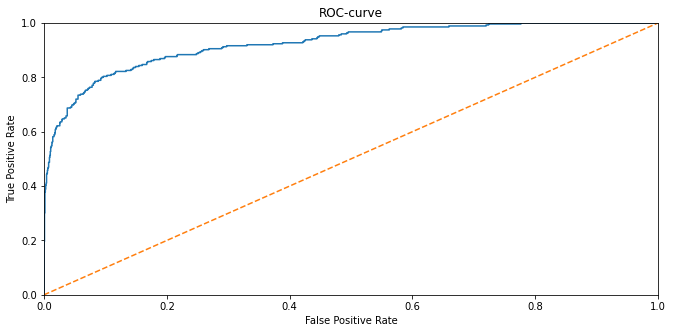

In [64]:
fpr, tpr, thresholds = roc_curve(target_test, target_proba)
plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC-curve')
    
plt.show()

Посмотрим на матрицу ошибок

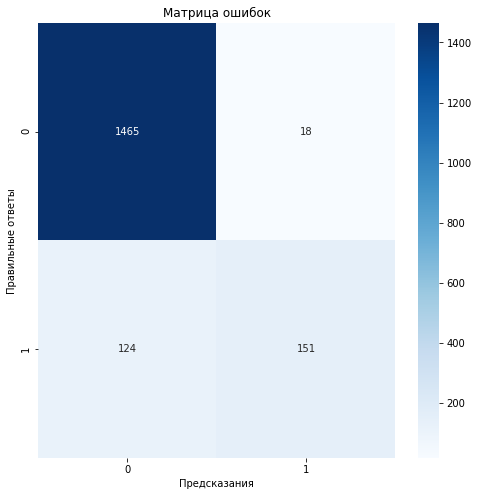

In [65]:
matrix = confusion_matrix(target_test, target_predict)
plt.figure(figsize=(8, 8))
sns.heatmap(matrix, 
                annot=True,  
                cmap='Blues', 
                fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show();

Модель достаточно хорошо предсказывает то, что клиент продолжить пользоваться услугами компании, и несколько хуже - в случае его отказа от услуг компании.
Выведем значимость признаков

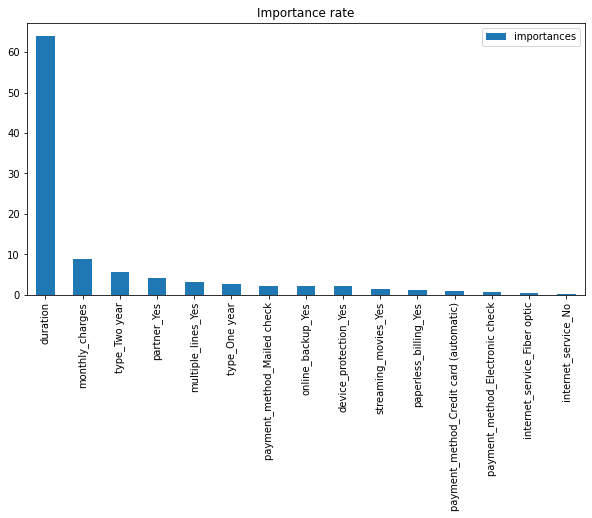

In [68]:
importance = pd.DataFrame(tuning_model_cb.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importance = importance.sort_values(by='importances', ascending=False)
importance.plot(kind='bar', figsize=(10, 5), title='Importance rate')
plt.show()

Два ключевых признака - время продолжительности сотрудничества клиента и компании и ежемесячный платеж.

### Вывод

Для обучения были выбраны четыре модели: LogisticRegression, DecisionTree, RandomForest и CatBoostClassifier.
При обучении моделей наилучшим образом себя показала модель CatBoostClassifier. На тестовой выборке она показала результаты
* ROC AUC: 0.9232894010911543
* Accuracy: 0.919226393629124

Матрица ошибок показала, что модель успешно предсказывает случаи продолжения сотрудничества клиента с компанией и несколько хуже - случаи ухода клиента.
Ключевыми признаками оказались продолжительность сотрудничества клиента и величина ежемесячного платежа.

## Отчет

Оператор связи хочет разработать модель прогнозирования оттока клиентов. Целью является выявление пользователей, которые планируют прекратить пользоваться услугами оператора. Для изучения предоставлены данные о клиентах, включая информацию о тарифах и договорах.

Компания предоставляет два типа услуг: стационарную телефонную связь и интернет. Интернет может быть подключен через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic). Также доступны дополнительные услуги: антивирус, блокировка небезопасных сайтов, выделенная линия технической поддержки, облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов.

Клиенты могут платить за услуги ежемесячно или заключить договор на 1-2 года. Также доступны различные способы расчета и возможность получения электронного чека.

__Пункты плана__

В ходе работы придерживались намеченного плана.

Во-первых, были подготовлены данные для анализа: данные были проверены на наличие пропусков и дубликатов, на правильный формат данных, приведены к единообразному виду и собраны в единую таблицу.

У ряда признаков был изменен тип данных: у признаков begin_date, end_date - на datetime, у признаков monthly_charges и total_charges на float, был добавлен признак duration означающий продолжительность времени использовния услуг заказчика его клиентом на момент выгрузки данных, что позволило посчитать срок для всех клиентов даже тех кто еще продолжает пользоваться, тем самым исключалась возможность утечки данных при обучении. Также перед обхединением были выделены два искуственных признака internet и phone, которые позщволили увидеть клиентов, пользующихся именно услугами интернет или услугами телефонии. 

Так же был выделен целевой признак clients_left означающий факт ухода клиента.

Перед обучением были удалены признаки begin_date, end_date.

После сборки целого датасета, образовались пропуски так как в 2х датасетах отсутсвует некоторое колличество клиентов, пропуски были заполнены значением No.

Во-вторых, был проведен анализ полученного датасета. Было проанализировано распределение целевого признака, а также распределение категориальных и количественных прищзнаков Был произведен анализ данных по тому, как разпределялась месячная плата между теми, кто ушели кто остался, выявилось, что уходят клиенты с большой ежемесячной платой. Также было подтверждено наблюдение, что клиенты с малой ежемесяцной платой в основном - пользователи услуг телефонии.

В ходе корреляционного анализа был выведен общий портрет клиента по категориальным признакам: предпочитает ежемесячную оплату услуг, чаще предпочитает электронные платежи и электронные чеки, предпочитает подключение по оптоволокну, не сильно любит подключать дополнительные услуги, чаще пользуется только телефонными услугами нежели только интернет услугами. При этом среди ушедших клиентов больше тех, кто приобретал услуг на большую сумму.

Также корреляционный анализ позволил удалить неинформативные признаки преед построением модели.

Помимо признаков begin_date, end_date были удалены следующие признаки: gender (отсутствие взаимосвязи с какой-либо из категорий),
senior_sitizens (есть корреляция с оплатой услуг, что может быть причиной ненулевой корелляции с целевым признаком, но скорее всего это не говорит о том, что пожилые клиенты покидают компанию из-за фактора возраста), dependents (есть корреляция с семейным положением, от чего и возникает корреляция с целевым признаком), internet и phone (искуственные признаки, введеные для первичного объединения таблиц и анализа), total_charges (высокая корреляция с признаком duration, что объясняется просто тем, что чем больше клиент остается с компанией, тем больше растет общая сумма его платежей).

В-третьих, были подготовлены данные для обучения моделе и произведен отбор моделей. Данные были разбиты на тестовую и обучающую выборки, признаки закодированы методом OHE. Из моделей были отобраны модель логистической регрессии, модель дерева решений, модель случайного леса, модель CatBoostClassifier. Перебор гиперпараметров позволил выделить модель, которая показывает лучшие результаты на выбраной метрике (ROC AUC) - модель CatBoostClassifier.

В качестве параметра   RANDOM_STATE была взята дата начала работы - 190623.

На базе этой модели с лучшими гиперпараметрами было произведено тестирование на тестовой выборке.

__Ключевые шаги в решении__ 

Ключевыми шагами в решении поставленной задачи были правильная и корректная обработка даных, их объединение, а затем и изучение. Было важно понять как все данные соединить так, чтобы не потерять ни один важный признак и информацию о клиентах. Причиной является небольшая величина датасета.

__Признаки для обучения модели__

На этапе подготовки к обучению модели были отобраны следующие признаки:

* type               
* paperless_billing   
* payment_method     
* monthly_charges  
* partner 
* internet_service 
* online_backup   
* device_protection 
* streaming_movies
* multiple_lines  
* duration

Качественные признаки были закодированы методом OHE, количественные признаки отмасштабированы через StandardScaler.


__Итоговая модель__

Лучшие результаты на обучающей выборке показала модель CatBoostClassifier.
Лучшими гиперпараметрами оказались:
* 'border_count': 128
* 'learning_rate': 0.1
* 'max_depth': 5
* 'n_estimators': 300

На тестовой выборке данная модель показала результаты:

* ROC AUC: 0.9232894010911543
* Accuracy: 0.919226393629124

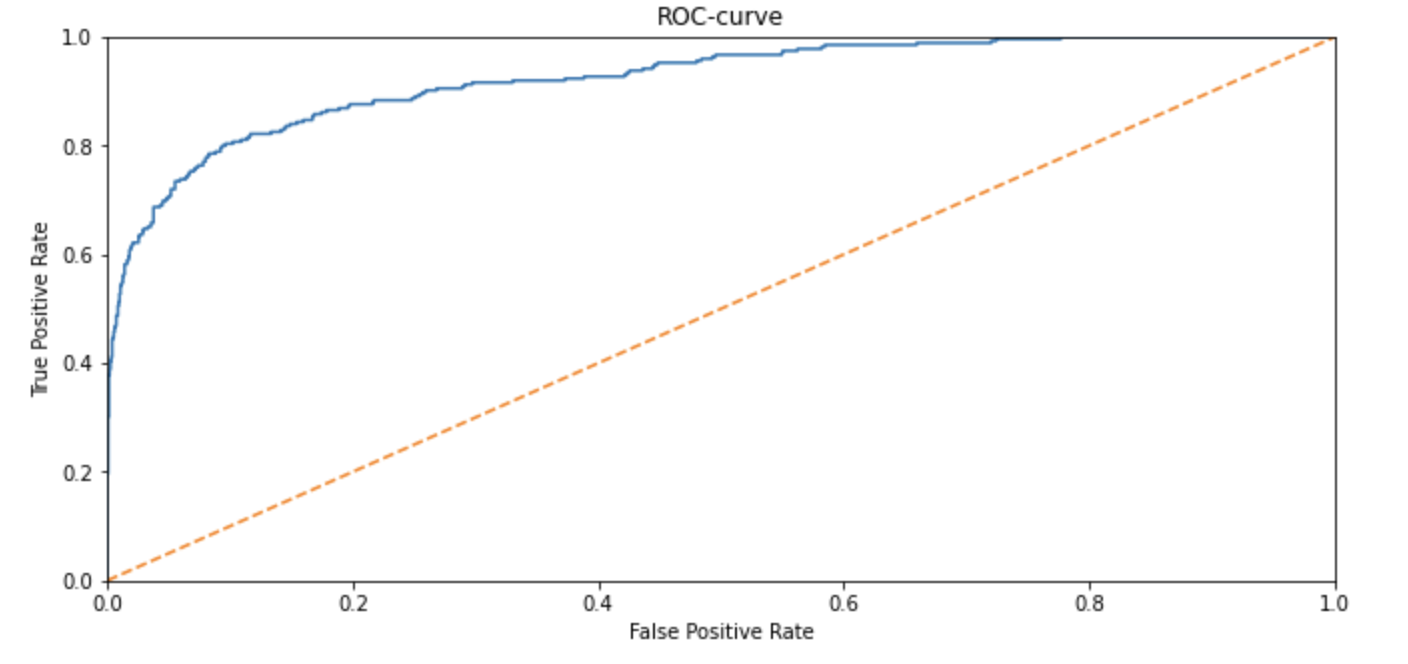





Матрица ошибок продемонстрировала, что модель успешно справляется с предсказанием того, что клиент продолжит пользоваться услугами компании, и хуже справляется с предсказанием того, что клиент уйдет.

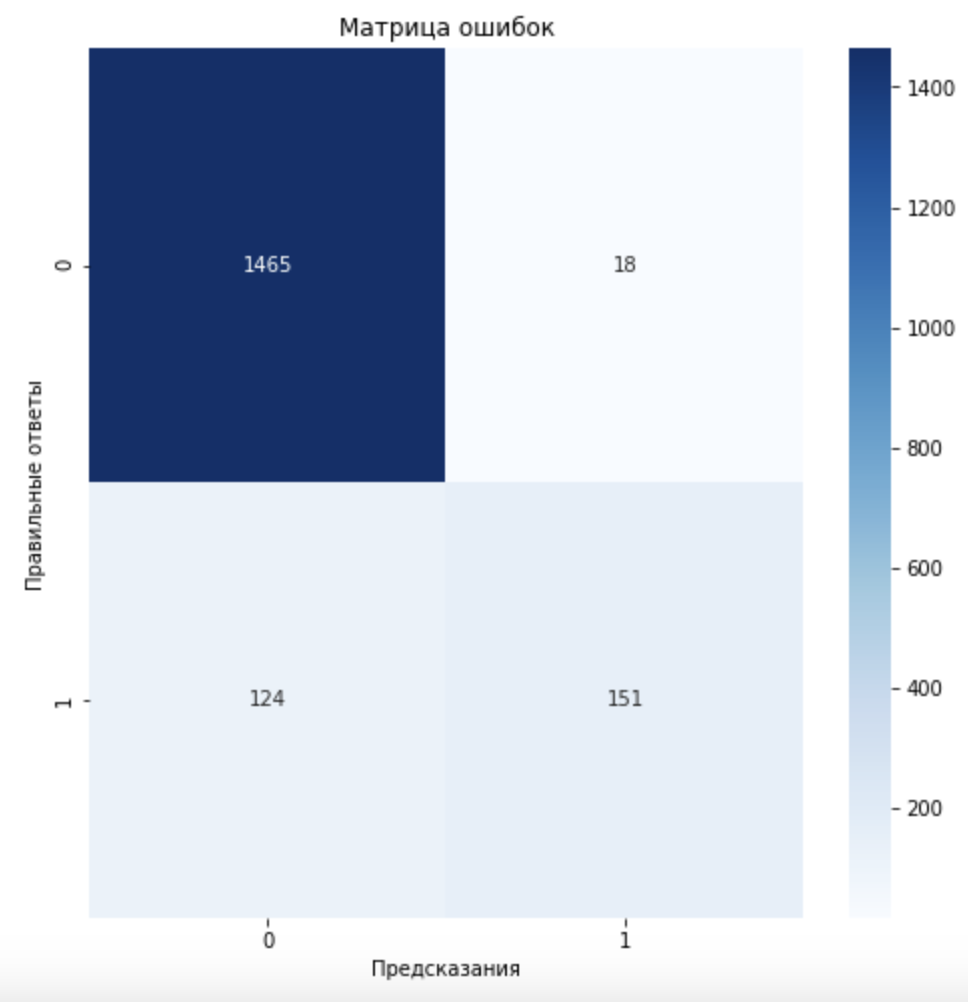


Двумя ключевыми признаками для работы модели стали признаки времеги продолжительности сотрудничества клиента и компании и признак ежемесячного платежа.

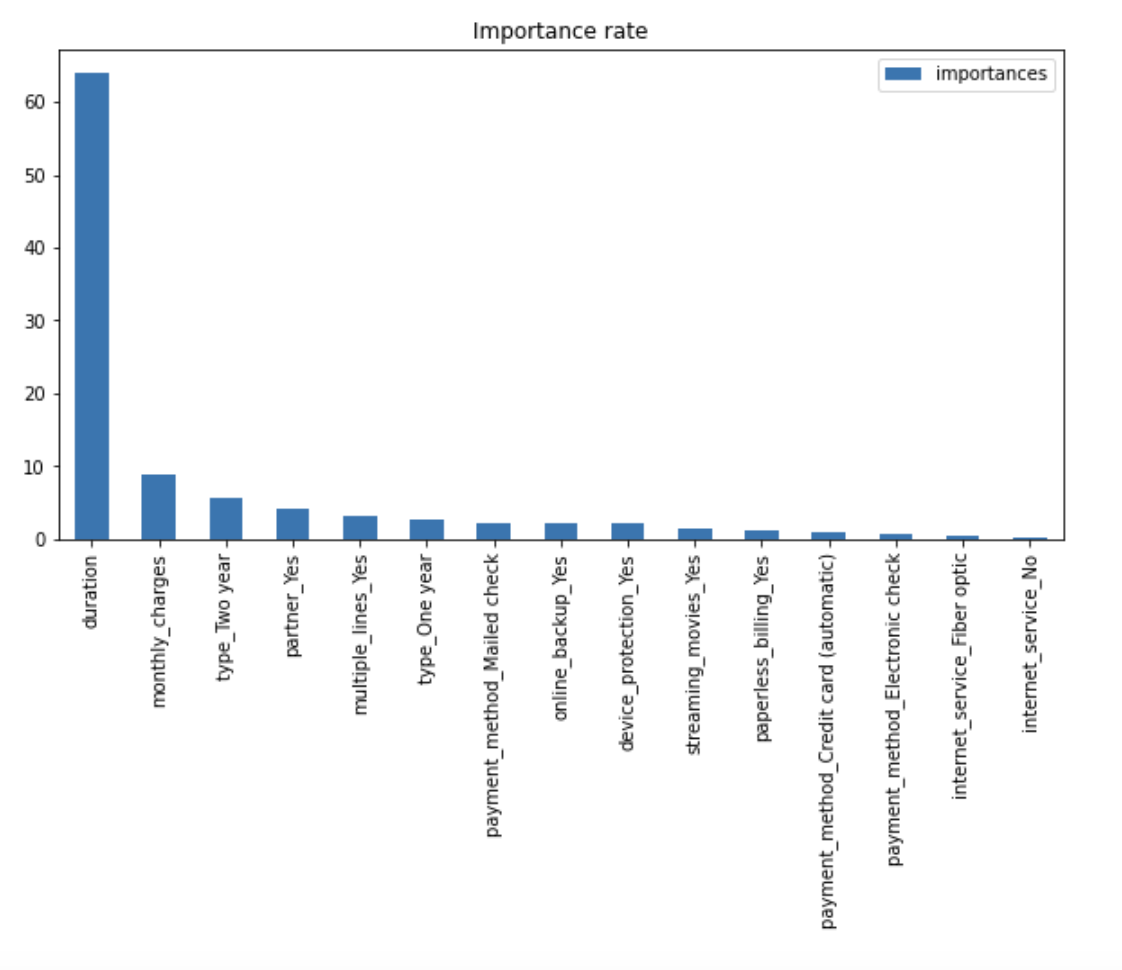

В целом, можно утверждать, что представленная модель достигает результатов, поставленых заказчиком проекта.